In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Importing benchmark datasets
Datasets are kept constant for benchmarking across the models in order to promote accurate comparison

In [8]:
file_path_X= 'train.csv'
X = pd.read_csv(file_path_X)

# file_path_y = '/content/y.csv_final'
y = X[['IMMEDR']]

file_path_X_test = 'test.csv'
X_test = pd.read_csv(file_path_X_test)

# file_path_y_test = '/content/y_test_final.csv'
y_test = X_test[['IMMEDR']]

C:\Users\priya\AppData\Local\Temp\ipykernel_37060\490377546.py:2: DtypeWarning: Columns (412,416,420,424,432,436,440,444,451,452,455,456,459,460,463,464,471,472,475,476,479,480,483,484,491,492,495,496,499,500,502,503,504,511,512,515,516,519,520,522,523,524,531,532,535,536,539,540,542,543,544,551,552,555,556,559,560,562,563,564,570,571,572,574,575,576,578,579,580,582,583,584,591,595,599,602,603,610,611,614,615,618,619,622,623,630,634,638,642,650,651,654,655,658,659,661,662,670,671,674,675,678,679,682,683,690,691,694,695,698,699,701,702,703,710,711,712,714,715,716,718,719,720,721,722,724,730,731,734,735,738,739,741,742,743,750,751,754,755,758,759,761,762,763,765,766,767,768,769,770,771,773,774,775,777,778,779,781,782,783,785,786,787,788,789,790,791,793,794,795,797,798,799,801,802,805,806,807,808,809,810,813,814,817,818,821,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,853,854,857,858,861,862,865,866,867,868,869,873,877,881) have m

# Preparing data for training XGBOOst baseline model
The model is built according to architecture specified by Menshawi & Hasssan (2023) https://doi.org/10.1111/exsy.13735. The paper provided the following hyper parameters for XGBoost: Validate_parameters = No, min split loss = 0.005, max depth = 4.

Features were selected for X in line with feature selectino for LLM models to ensure consistency, with additional preprocessing to ensure compatability with XGBoost requirements for data input

In [9]:
#isolating features of interest for triaging
features = ["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "ETOHAB", "ALZHD", "ASTHMA", "CANCER", "CEBVD", "CKD", "COPD", "CHF", "CAD", "DEPRN", "DIABTYP1", "DIABTYP2", "DIABTYP0", "ESRD", "HPE", "EDHIV", "HYPLIPID", "HTN", "OBESITY", "OSA", "OSTPRSIS", "SUBSTAB", "CAUSE1"]
X = X[features]
X_test = X_test [features]

In [10]:
X.loc[X['TOTCHRON'] == "'None' box and all item fields are blank", 'TOTCHRON'] = 0
X_test.loc[X_test['TOTCHRON'] == "'None' box and all item fields are blank", 'TOTCHRON'] = 0
for col in ["ETOHAB", "ALZHD", "ASTHMA", "CANCER", "CEBVD", "CKD", "COPD", "CHF", "CAD", "DEPRN", "DIABTYP1", "DIABTYP2", "DIABTYP0", "ESRD", "HPE", "EDHIV", "HYPLIPID", "HTN", "OBESITY", "OSA", "OSTPRSIS", "SUBSTAB"]:
    X[col] = X[col].map({'Yes': 1, 'No': 0})
    X_test[col] = X_test[col].map({'Yes': 1, 'No': 0})

In [11]:
X.dtypes

AGE           int64
SEX          object
ARREMS       object
RFV1         object
TEMPF        object
PULSE        object
BPSYS        object
BPDIAS       object
RESPR        object
POPCT        object
PAINSCALE    object
TOTCHRON     object
INJURY       object
ETOHAB        int64
ALZHD         int64
ASTHMA        int64
CANCER        int64
CEBVD         int64
CKD           int64
COPD          int64
CHF           int64
CAD           int64
DEPRN         int64
DIABTYP1      int64
DIABTYP2      int64
DIABTYP0      int64
ESRD          int64
HPE           int64
EDHIV         int64
HYPLIPID      int64
HTN           int64
OBESITY       int64
OSA           int64
OSTPRSIS      int64
SUBSTAB       int64
CAUSE1       object
dtype: object

In [12]:
#Converting features into data type usable by the model - converting object columns to numeric or categorical
for col in features:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
            X_test[col] = pd.to_numeric(X_test[col])
        except ValueError:
            X[col] = X[col].astype('category')
            X_test[col] = X_test[col].astype('category')

In [13]:
X.dtypes

AGE             int64
SEX          category
ARREMS       category
RFV1         category
TEMPF        category
PULSE        category
BPSYS        category
BPDIAS       category
RESPR        category
POPCT        category
PAINSCALE    category
TOTCHRON        int64
INJURY       category
ETOHAB          int64
ALZHD           int64
ASTHMA          int64
CANCER          int64
CEBVD           int64
CKD             int64
COPD            int64
CHF             int64
CAD             int64
DEPRN           int64
DIABTYP1        int64
DIABTYP2        int64
DIABTYP0        int64
ESRD            int64
HPE             int64
EDHIV           int64
HYPLIPID        int64
HTN             int64
OBESITY         int64
OSA             int64
OSTPRSIS        int64
SUBSTAB         int64
CAUSE1       category
dtype: object

In [17]:
# Map triage levels to numerical labels
triage_mapping = {
    "Immediate": 0,
    "Emergent": 1,
    "Urgent": 2,
    "Semi-urgent": 3,
    "Nonurgent": 4
}
y['IMMEDR'] = y['IMMEDR'].map(triage_mapping)
y_test['IMMEDR'] = y_test['IMMEDR'].map(triage_mapping)

## Building and training the model


In [23]:
import xgboost as xgb

In [15]:
# model instantiated based on defined hyperparametrs
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class probabilities
    num_class= 5,                 #5 classes of triage to predict
    gamma=0.005, #defined by paper
    max_depth=4, #defined by paper
    validate_parameters=False, #defined by paper
    eval_metric='mlogloss', #for AUC calc
    enable_categorical=True #for categorised x features
)


In [18]:
#training model
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.005,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5, ...)

#Evaluation metrics for comparison across models

Temperature: 0.50, NLL: 2.5786
Temperature: 0.75, NLL: 1.9287
Temperature: 1.00, NLL: 1.6404
Temperature: 1.25, NLL: 1.4913
Temperature: 1.50, NLL: 1.4084
Temperature: 1.75, NLL: 1.3612
Temperature: 2.00, NLL: 1.3347
Temperature: 2.25, NLL: 1.3208
Temperature: 2.50, NLL: 1.3147
Temperature: 2.75, NLL: 1.3135
Temperature: 3.00, NLL: 1.3156
 Optimal Temperature: 2.75, NLL: 1.3135
 Metrics with Temperature Calibration
Accuracy: 0.4059
AUC: 0.5988
Mean Predicted Probability: 0.6267


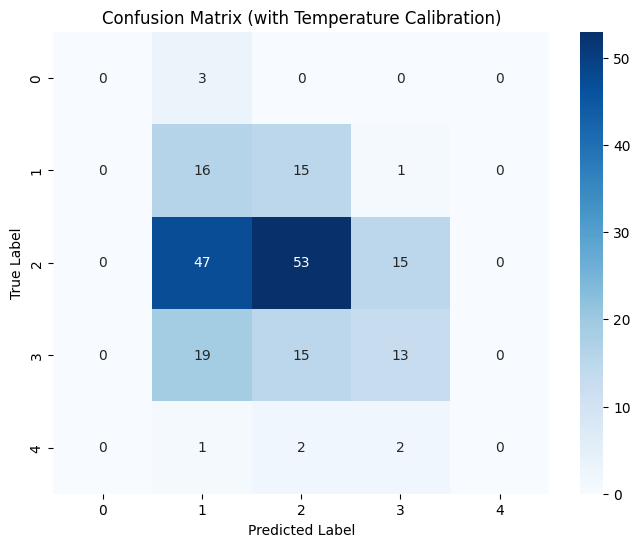

Mean Entropy with Optimal Temperature: 1.3212


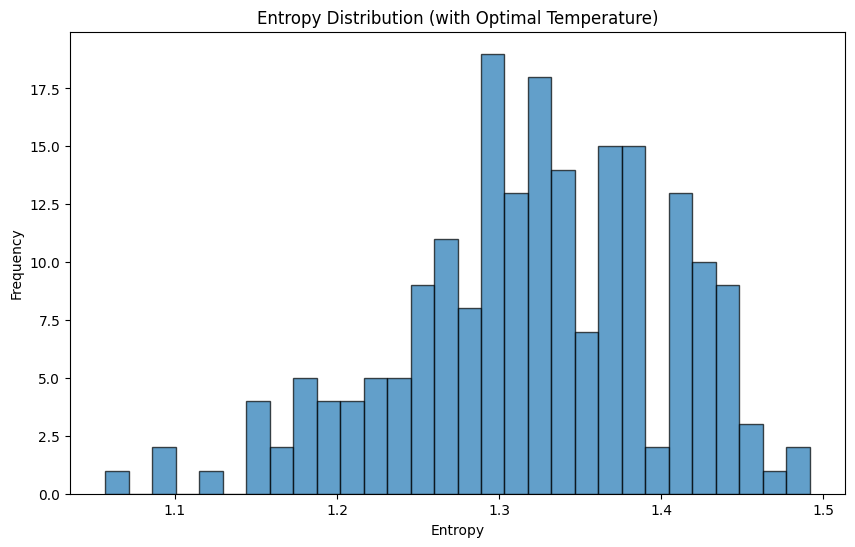

In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn.functional as F

# Generating predictions
y_preds = xgb_model.predict(X_test)

# Generating predictions for class probabilities
y_proba = xgb_model.predict_proba(X_test)
y_true = y_test.to_numpy() #convert to numpy array for later conversion to tensor

# Convert softmaxed probabilities to logits for consistency with evaluation metrics
epsilon = 1e-8  # avoids error from log 0
clipped_probs = np.clip(y_proba, epsilon, 1 - epsilon)
logits = np.log(clipped_probs)

# Convert to torch tensor
logits_tensor = torch.tensor(logits)
labels_tensor = torch.tensor(y_true)

# defining softmax functions with temp scaling acc. to method for languagew models
def apply_temperature(logits, temperature):
    return logits / temperature

def softmax_with_temperature(logits, temperature):
    scaled_logits = apply_temperature(logits, temperature)
    return F.softmax(scaled_logits, dim=1)

def negative_log_likelihood(probs, labels):
    labels = torch.tensor(labels)
    probs_tensor = torch.tensor(probs)
    correct_class_probs = probs_tensor[range(len(labels)), labels]
    nll = -torch.mean(torch.log(correct_class_probs + 1e-8))
    return nll.item()

def find_optimal_temperature(logits, labels, temperature_values):
    best_temp = None
    best_nll = float("inf")
    for temp in temperature_values:
        probs_temp = softmax_with_temperature(logits, temp).detach().numpy()
        nll = negative_log_likelihood(probs_temp, labels)
        print(f"Temperature: {temp:.2f}, NLL: {nll:.4f}")
        if nll < best_nll:
            best_nll = nll
            best_temp = temp
    return best_temp, best_nll

#finding optimal temperature for model perfomance
temperature_values = np.linspace(0.5, 3.0, 11)  # e.g., [0.5, 0.75, ..., 3.0]
optimal_temp, optimal_nll = find_optimal_temperature(logits_tensor, y_true, temperature_values)
print(f" Optimal Temperature: {optimal_temp:.2f}, NLL: {optimal_nll:.4f}")

#calculate optimal probability and prediction functions
optimal_probs = softmax_with_temperature(logits_tensor, optimal_temp).detach().numpy()
optimal_preds = np.argmax(optimal_probs, axis=1)

#Calculate evalution metrics at optimal temperature
accuracy_opt = accuracy_score(y_true, optimal_preds)
auc_opt = roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted")
cm_opt = confusion_matrix(y_true, y_preds)
mean_prob_opt = np.mean(np.max(y_proba, axis=1))

#print metrics
print(" Metrics with Temperature Calibration")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"AUC: {auc_opt:.4f}")
print(f"Mean Predicted Probability: {mean_prob_opt:.4f}")

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (with Temperature Calibration)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#calculate entropy
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-8), axis=1)

entropy_values = calculate_entropy(optimal_probs)
mean_entropy = np.mean(entropy_values)

#plot entropy across optimal temperature
print(f"Mean Entropy with Optimal Temperature: {mean_entropy:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(entropy_values, bins=30, edgecolor='k', alpha=0.7)
plt.title("Entropy Distribution (with Optimal Temperature)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()


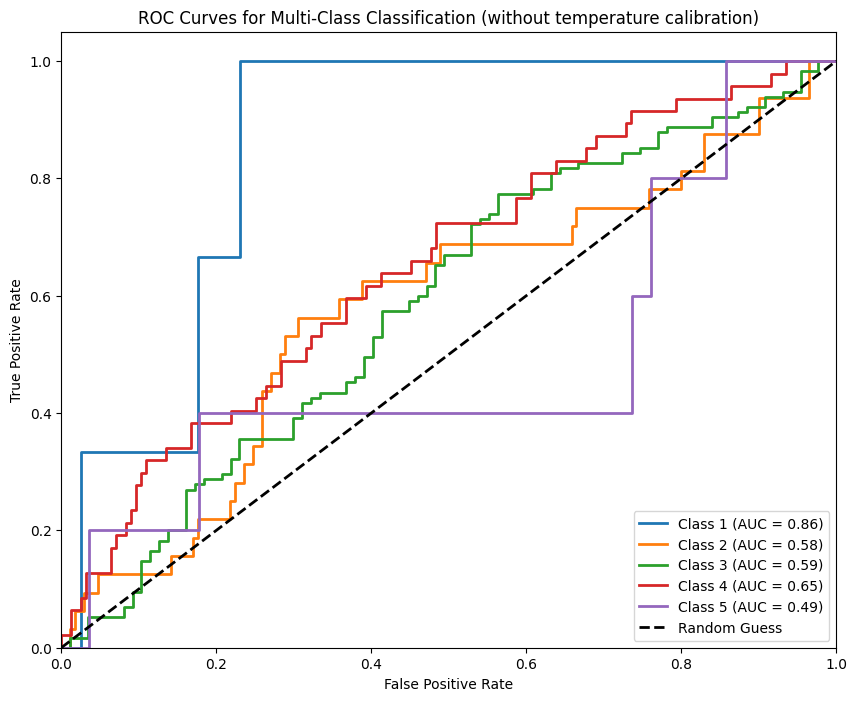

In [25]:
# Plot ROC Curves for Multi-Class (without temperature calibration)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

n_classes = y_proba.shape[1]
labels_binarized = label_binarize(y_test, classes=list(range(n_classes)))
fpr = {}
tpr = {}
roc_auc_dict = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], optimal_probs[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i+1} (AUC = {roc_auc_dict[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification (without temperature calibration)")
plt.legend(loc="lower right")
plt.show()

## Predicting over and under triaging

In [38]:
wrong_mask = y_preds != y_test['IMMEDR']
if np.any(wrong_mask):
    pct_over = np.mean(y_preds[wrong_mask] > y_test['IMMEDR'][wrong_mask]) * 100
    pct_under = np.mean(y_preds[wrong_mask] < y_test['IMMEDR'][wrong_mask]) * 100
else:
    pct_over = pct_under = 0

print(f"Over-triage: {pct_over:.2f}%")
print(f"Under-triage: {pct_under:.2f}%")

Over-triage: 28.33%
Under-triage: 71.67%
